Processing Samples: 100%|██████████| 201/201 [1:27:10<00:00, 26.02s/it]
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


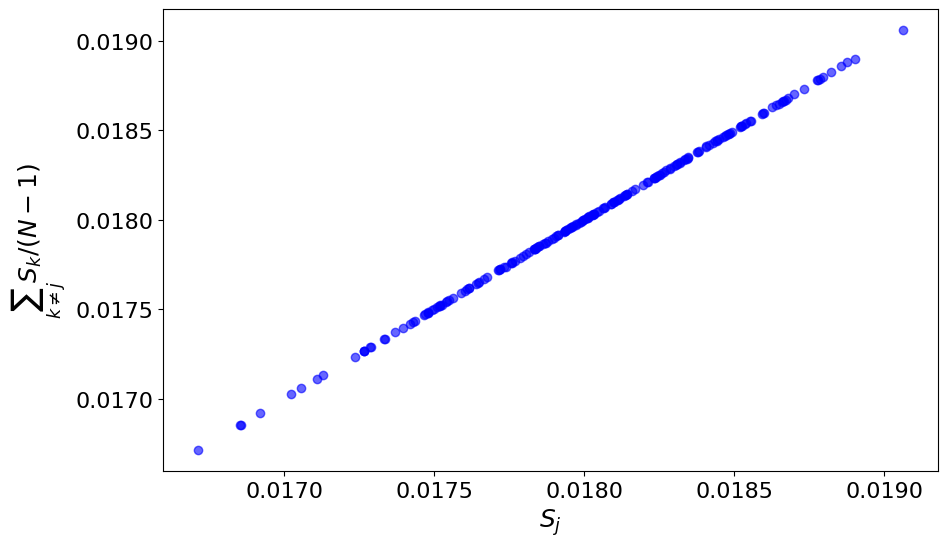

In [ ]:
import numpy as np
import time
from tqdm import tqdm
import matplotlib.pyplot as plt

# エージェントの基本クラス
class Agent:
    def __init__(self, initial_action):
        # 初期行動量を設定
        self.action = initial_action
        # 累積利得の初期化
        self.total_payoff = 0.0

    def update_payoff(self, payoff):
        # 累積利得を更新
        self.total_payoff += payoff


# ZD戦略を持つエージェントクラス
class ZDAgent(Agent):
    def __init__(self, x0ov, x0und, W, kappa, chi):
        # 定数を辞書として定義
        self.actions = {
            "x_ov": x0ov,
            "x_und": x0und
        }
        super().__init__(self.actions["x_ov"])
        self.W = W
        self.kappa = kappa
        self.chi = chi
        self.current_action_key = "x_ov"

    def choose_action(self, B):
        # Bに基づき次の行動確率 T0 を計算し、行動を選択
        T0 = self.calculate_probability(B)
        if np.random.random() <= T0:
            self.action = self.actions["x_und"]
            self.current_action_key = "x_und"
        else:
            self.action = self.actions["x_ov"]
            self.current_action_key = "x_ov"

    def calculate_probability(self, B):
        # 行動確率 T0 を現在の行動状態に基づき計算
        return B / self.W + 1.0 if self.current_action_key == "x_und" else B / self.W

# 通常のエージェントクラス（特別な戦略は持たない）
class NormalAgent(Agent):
    def __init__(self, a, b, c, N):
        # 定数を辞書として定義
        self.actions = {
            "xc": (a - c) / (2 * N * b),
            "xn": (a - c) / ((N + 1) * b)
        }
        # 初期行動をランダムに選択
        initial_action_key = "xc" if np.random.random() < 0.5 else "xn"
        super().__init__(self.actions[initial_action_key])
        self.a = a
        self.b = b
        self.c = c
        self.N = N
        self.current_action_key = initial_action_key
        self.action_prob_list = np.random.rand(36)  # 各行動履歴に基づく確率リスト
        self.prev_action_index = 0  # 前回の行動状況に応じたリストのインデックス

    def choose_action(self, zd_action, other_actions, zd_actions):
        # ZDエージェントの行動が x0ov か x0und かを文字列で判定
        zd_discrete = 1 if zd_action == zd_actions["x_und"] else 0
        
        # 自分の行動が xc か xn かを文字列で判定
        self_discrete = 1 if self.current_action_key == "xc" else 0
        
        # 他のエージェントの行動状況をカウント
        other_count = sum(1 for action in other_actions if action == self.actions["xc"])

        # ZDエージェント、自分、他のエージェントの行動状況でリストのインデックスを決定
        self.prev_action_index = zd_discrete * 18 + self_discrete * 9 + other_count

        # 確率に基づき行動を選択
        if np.random.random() < self.action_prob_list[self.prev_action_index]:
            self.action = self.actions["xc"]  
            self.current_action_key = "xc"
        else:
            self.action = self.actions["xn"]
            self.current_action_key = "xn"

# ステップ関数 
def theta(y):
    return 1.0 if y >= 0 else 0.0

# 各エージェントの利得を計算
def calculate_payoffs(agents, a, b, c):
    # 全エージェントの供給量の合計 xtot を計算
    xtot = sum(agent.action for agent in agents)

    # 各エージェントの利得を計算し、累積利得を更新
    for agent in agents:
        payoff = ((a - b * xtot) * theta(a - b * xtot) - c) * agent.action
        agent.update_payoff(payoff)

# クールノー寡占ゲームのシミュレーション
def run_simulation(N, NTIME, NSAMPLE, a, b, c, xmax, chi, kappa):
    results = [] 
    W = 2.0 * c * xmax + abs((chi - 1) * kappa)   
    x0ov = chi / (chi + N - 1.0) * (a - c) / b 
    x0und = xmax 
    zd_actions = {"x_ov": x0ov, "x_und": x0und}

    # 各サンプルについてシミュレーションを実行
    for ioppo in tqdm(range(NSAMPLE + 1), desc="Processing Samples"):

        # ZDエージェントと通常エージェントを初期化
        agents = [ZDAgent(x0ov, x0und, W, kappa, chi)]
        agents.extend(NormalAgent(a, b, c, N) for _ in range(1, N))
        
        # 初期の B の計算
        B = agents[0].total_payoff + (chi - 1.0) * kappa
        for agent in agents[1:]:
            B -= chi / (N - 1) * agent.total_payoff

        # 各エージェントが NTIME 回行動する
        for _ in range(NTIME):
            # ZDエージェントが次の行動を選択
            agents[0].choose_action(B)

            # 通常エージェントの行動選択
            for i in range(1, N):
                other_actions = [agent.action for j, agent in enumerate(agents) if j != i]
                agents[i].choose_action(agents[0].action, other_actions, zd_actions)

            # 全エージェントの利得を計算
            calculate_payoffs(agents, a, b, c)

            # ZD戦略に基づく B の更新
            B = (
                agents[0].total_payoff
                - chi / (N - 1) * sum(agent.total_payoff for agent in agents[1:])
                + (chi - 1.0) * kappa
            )

        # ZDエージェントと他のエージェントの平均利得を計算
        S0_avg = agents[0].total_payoff / NTIME
        Smj_avg = sum(agent.total_payoff for agent in agents[1:]) / (N - 1) / NTIME
        results.append((S0_avg, Smj_avg))  

    return results  

# 結果をテキストファイルに保存
def save_results_to_file(results, filename="results.txt"):
    with open(filename, 'w') as file:
        file.write("S0_avg, Smj_avg\n")
        for S0_avg, Smj_avg in results:
            file.write(f"{S0_avg}, {Smj_avg}\n")

# 結果をプロット
def plot_results(results):
    S0_avg_values, Smj_avg_values = zip(*results) 
    plt.figure(figsize=(10, 6))
    plt.scatter(S0_avg_values, Smj_avg_values, color='blue', alpha=0.6)
    plt.xlabel(r"Payoff of the focal player, $S_j$", fontsize=20)
    plt.ylabel(r"Average payoff of the co-players, $\sum_{k \ne j} S_k / (N - 1)$", fontsize=14)
    plt.xticks(fontsize=18)
    plt.yticks(fontsize=18)
    plt.savefig("S0_avg_vs_Smj_avg.eps", format='eps', bbox_inches='tight') 
    plt.show()


if __name__ == "__main__":
    # 乱数シードを設定
    np.random.seed(int(time.time()))

    # ゲームのパラメータ
    N = 10  
    NTIME = 1000000
    a, b, c, xmax = 2.0, 1.0, 1.0, 2.5 
    chi, kappa = 1.0, 0.0
    NSAMPLE = 200 

    # シミュレーション実行
    results = run_simulation(N, NTIME, NSAMPLE, a, b, c, xmax, chi, kappa)

    # 結果をテキストファイルに保存
    save_results_to_file(results, "simulation_results.txt")

    # 結果をプロット
    plot_results(results)




The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


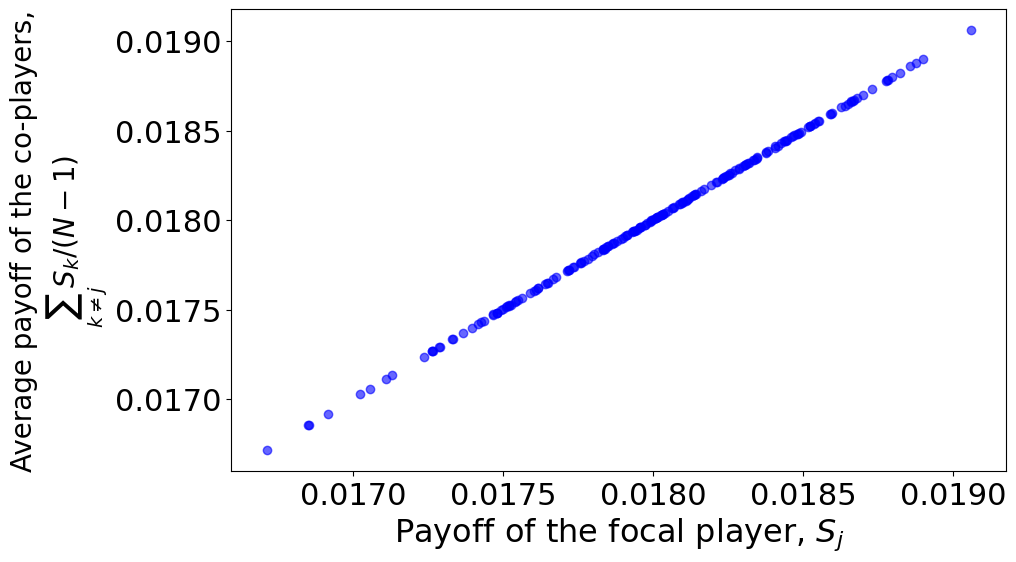

In [11]:
import matplotlib.pyplot as plt

# 結果をファイルから読み込む関数
def load_results_from_file(filepath):
    results = []
    with open(filepath, 'r') as file:
        next(file)  # ヘッダ行をスキップ
        for line in file:
            cols = line.strip().split(",")
            if len(cols) == 2:
                S0_avg, Smj_avg = map(float, cols)
                results.append((S0_avg, Smj_avg))
    return results

# 結果をプロットする関数
def plot_results(results):
    S0_avg_values, Smj_avg_values = zip(*results) 
    plt.figure(figsize=(10, 6))
    plt.scatter(S0_avg_values, Smj_avg_values, color='blue', alpha=0.6)
    plt.xlabel(r"Payoff of the focal player, $S_j$", fontsize=23)
    plt.ylabel(
        "Average payoff of the co-players,\n" + r"$\sum_{k \ne j} S_k / (N - 1)$",
        fontsize=20
    )
    plt.xticks(fontsize=22)
    plt.yticks(fontsize=22)
    plt.savefig("S0_avg_vs_Smj_avg_fig2.eps", format='eps', bbox_inches='tight') 
    plt.show()

if __name__ == "__main__":
    filepath = r"C:\Users\shoma\Downloads\simulation_results.txt"
    results = load_results_from_file(filepath)
    plot_results(results)
